In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Loading Data Set 1: GDSC 

Please note that before running the code, you will need all the GDSC files. They can be found on the drive (https://drive.google.com/drive/u/1/folders/11omvpOttkdZZgv_ppbtcCbojkuVR-D61) or directly on the GDSC website.

In [29]:
NB_DRUGS = 10 #number of best drugs to select
SCORE = "AUC" #how the sensitivity of the drug is computed; other option: "AUC" 
SAVE = True #whether to save the final matrix or not
PATH = "data/GDSC/" #where your data is located

#### Cell populations and labels

File which represents how well each cell population reacted to each drug. 

1. How is the drug measured?

    a. **IC50:** describes the concentration of an inhibitor that results in a half-maximal inhibition of a response (i.e. the concentration that reduces a response to 50% of its maximum). That maximum response being inhibited is due to the action of something else (typically an agonist for the receptor of interest). Maximum IC50 = 8. Minimum IC50 = 0. 
    
    IC50 is obtained by plotting a measure of the cell death rate vs the concentration of the drug. IC50 is expressed as a concentration so the higher the concentration of drug needed to kill the cell line the more resistant that cell line is. If the IC50 is very low then the concentration (or amount) of drug needed to kill the cell line is also very low which means the cell line is more sensitive. Typically you get a S curve or sigmoidal curve. IC50 is the middle point of the sigmoidal curve. The threshold for calling a drug sensitive/resistant changes depending upon the IC50 value and we need to see how the sigmoidal curve behaves.
    
    d.	**ActArea:** "*Sensitivity was assayed by measuring cellular ATP levels as a surrogate  for cell number and growth. Raw data were merged with assay metadata, and percent-viability scores were calculated relative to DMSO controls, after which concentration-response curves were fit for percent viability. The areas under percent-viability curves were computed and used as the measure of sensitivity*". In one paper, the limit was set to **0.8 SD**. Sensitive cell lines were the ones with an activity area at least 0.8 SD above the mean. Resistant cell lines had an activity area at least 0.8 SD below the mean. All other samples were discared.
    


In [ ]:
conversion = pd.read_excel(PATH + "GDSC_CCLE_conversion.xlsx")[["GDSC1000 cosmic id","GDSC1000 name","CCLE name"]]
conversion.head()

In [ ]:
responses = pd.read_excel(PATH + "Fitted_dose_response.xlsx")
responses.head()

In [ ]:
#Information about data set 

print("Number of different drugs: ",len(responses["DRUG_NAME"].unique()))
print("Number of different cell lines: ", len(responses["CELL_LINE_NAME"].unique()))
print("Total number of tests: ", len(responses.index))
print("Number of tests and cells per drug compounds:")
response_summary = responses.groupby(["DRUG_NAME"])["CELL_LINE_NAME"].agg(['count','nunique']).sort_values(["count"], ascending = False)
response_summary.rename(index = str, columns = {'count': "Number of tests", "nunique" : 'Number of unique cell populations'}, inplace = True)
display(response_summary)

In [ ]:
#Select drugs

selected_drugs = response_summary.index[:NB_DRUGS].values.tolist() #select the drugs
best_responses = responses[responses["DRUG_NAME"].isin(selected_drugs)] #filter the responses df to keep only the ones of selected drugs
best_responses = pd.merge(left = best_responses, right = conversion, how = 'left', left_on = 'COSMIC_ID', right_on = "GDSC1000 cosmic id") #add the corresponding CCLE names
best_responses = best_responses.drop(labels = ["DATASET_VERSION", "IC50_RESULTS_ID", "PUTATIVE_TARGET","MAX_CONC_MICROMOLAR", "MIN_CONC_MICROMOLAR", "RMSE", "Z_SCORE", "GDSC1000 cosmic id", "GDSC1000 name"], axis = 1)
best_responses.head()

In [ ]:
#Missing elements

print("Number of elements before dropping missing values", len(best_responses.index))
best_responses = best_responses.dropna(axis = 0)
print("Number of elements after dropping missing values", len(best_responses.index))
best_responses.head()

In [ ]:
print('Percentage of Null Values in Each Column:')
for column in best_responses:
    print(column,(best_responses[column].isnull().sum())/len(best_responses)*100)

In [ ]:
final_response_matrix = best_responses.pivot_table(index = "CCLE name", columns = "DRUG_NAME", values = SCORE)
if SAVE:
    final_response_matrix.to_csv(PATH + 'final_response_matrix.csv')
final_response_matrix.head()

In [ ]:
print("Total number of cell populations for each drug:")
display(final_response_matrix.count(axis = 0).sort_values(ascending = False))

In [ ]:
print("How many NaN values do we have per drug compound ?")
display(pd.DataFrame(final_response_matrix.isnull().sum(axis = 0)).T)
print("Total number of missing values: ", final_response_matrix.isnull().sum().sum())

There are also other datasets provided by GDSC.

In [ ]:
drugs = pd.read_csv(PATH + "Drugs.csv") #provides information on the different drugs
drugs.head()

In [ ]:
cells = pd.read_csv(PATH + "Cells.csv") #provides information on the different cell populations 
cells.head()

In [ ]:
features = pd.read_csv(PATH + "Features.csv") #provides information on the different types of alterations
features.head()

## Loading Data Set 2: Mutations

File which represents the presence of mutations in these same cell populations.

0 = mutation is not present

1 = mutation is present

In [ ]:
alterations = pd.read_csv("data/Alterations.txt", sep  = '\t').set_index('Description').transpose()
alterations.head()

### Merging Mutation and Drug Response Data

In [ ]:
drug_name = 'JQ1'
ML_matrix = alterations.merge(final_response_matrix[[drug_name]], left_index = True, right_index = True).dropna(axis = 0)
ML_matrix.head()

In [30]:
DRUG_NAMES = ["CI-1040", "PD0325901","Refametinib","VX-11e","Afatinib","Pelitinib"]

In [31]:
DRUG_NAME = DRUG_NAMES[0]
ML_matrix = pd.read_csv(f"data/Final matrices/{DRUG_NAME}_full.csv")
ML_matrix.set_index("Cell_line", inplace = True)

Quick look at the distribution.

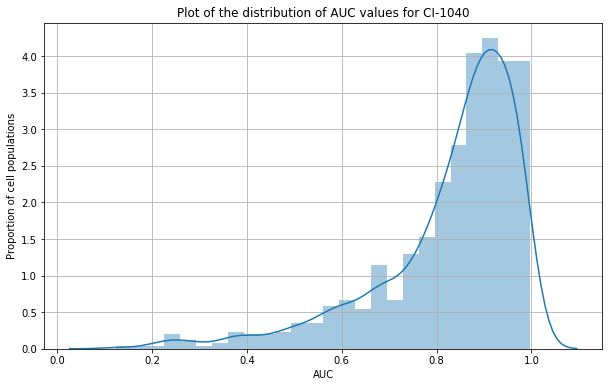

In [32]:
fig = plt.figure(figsize = (10,6))
sns.distplot(ML_matrix[[DRUG_NAME]])
plt.title("Plot of the distribution of AUC values for "+ DRUG_NAME)
plt.xlabel("AUC")
plt.ylabel("Proportion of cell populations")
plt.grid(True);

### Categorization of Resistant vs. Sensitive 

Everything that's above the mean + 0.5 $\times$ the standard deviation (high IC50) is classified as "resistant" wheras eveything below the mean - 0.5 $\times$ the standard deviation is classified at "sensitive". Everything that is in the middle is discarded.

In [33]:
print("The lower threshold used here is the lower third quartile = ", ML_matrix[DRUG_NAME].quantile([0.25,0.75])[0.25])
print("The upper threshold used here is the uppder third quartile = ", ML_matrix[DRUG_NAME].quantile([0.25,0.75])[0.75])
ML_matrix["Response"] = pd.cut(ML_matrix[DRUG_NAME], [np.min(ML_matrix[DRUG_NAME]), ML_matrix[DRUG_NAME].quantile([0.25,0.75])[0.25], ML_matrix[DRUG_NAME].quantile([0.25,0.75])[0.75], np.max(ML_matrix[DRUG_NAME])], labels = ["sensitive","medium", "resistant"])
ML_matrix = ML_matrix.drop([DRUG_NAME], axis = 1)
ML_matrix

The lower threshold used here is the lower third quartile =  0.7740724975
The upper threshold used here is the uppder third quartile =  0.9318325812499999


,PLCH2_mut,UBE4B_mut,ADGRB2_mut,ZSCAN20_mut,SZT2_mut,MOB3C_mut,ZFYVE9_mut,ST6GALNAC3_mut,TCHH_mut,HRNR_mut,...,DMTF1_del,PPP4R1_del,CDH1_del,SLC12A6_del,PTBP3_del,KCNE2_del,DGCR2_del,CASP8AP2_del,SCO2_del,Response
Cell_line,,,,,,,,,,,,,,,,,,,,,
22RV1_PROSTATE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,resistant
A253_SALIVARY_GLAND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,resistant
A427_LUNG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
A431_SKIN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium
A4FUK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,medium
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,medium
BICR78_UPPER_AERODIGESTIVE_TRACT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
CADOES1_BONE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,resistant
CCFSTTG1_CENTRAL_NERVOUS_SYSTEM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,resistant


In [34]:
#Drop all the "medium" classes
ML_matrix = ML_matrix.drop(ML_matrix[ML_matrix["Response"] == "medium"].index)
ML_matrix = ML_matrix.dropna()  
ML_matrix.head()

,PLCH2_mut,UBE4B_mut,ADGRB2_mut,ZSCAN20_mut,SZT2_mut,MOB3C_mut,ZFYVE9_mut,ST6GALNAC3_mut,TCHH_mut,HRNR_mut,...,DMTF1_del,PPP4R1_del,CDH1_del,SLC12A6_del,PTBP3_del,KCNE2_del,DGCR2_del,CASP8AP2_del,SCO2_del,Response
Cell_line,,,,,,,,,,,,,,,,,,,,,
22RV1_PROSTATE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,resistant
A253_SALIVARY_GLAND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,resistant
A427_LUNG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
BICR78_UPPER_AERODIGESTIVE_TRACT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
CADOES1_BONE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,resistant


In [35]:
# Convert response to float
ML_matrix["Response"] = [0 if x=='resistant' else 1 for x in ML_matrix['Response']]

In [36]:
# Looking at class balance
print(f"Structure of the final matrix for {DRUG_NAME}:")
print("\tNumber of resistant cells: ", len(ML_matrix[ML_matrix["Response"] == 0]))
print("\tNumber of sensitive cells: ", len(ML_matrix[ML_matrix["Response"] == 1]))
print("\tTotal number of cells: ", len(ML_matrix.index))
print(f'\n\tThe baseline accuracy for {DRUG_NAME} is {100*np.round(len(ML_matrix[ML_matrix["Response"] == 1])/len(ML_matrix.index),2)}%')    

Structure of the final matrix for CI-1040:
	Number of resistant cells:  190
	Number of sensitive cells:  189
	Total number of cells:  379

	The baseline accuracy for CI-1040 is 50.0%


We see that our classes are more or less equal (which is good!). 

### Feature Selection Using PCA

Number of features before PCA:  64144


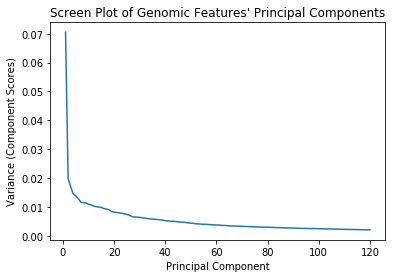

Number of combined features after PCA:  120


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119
0,13.706563,-1.830432,0.291761,1.417602,-3.456869,-0.415246,-0.821973,-0.383194,-1.626654,1.439796,...,-0.071292,0.271940,-0.120444,0.062469,-0.001434,-0.001332,0.048227,-0.005693,-0.256729,-0.157125
1,-1.767892,8.002435,-11.708761,-0.542897,-1.351026,-4.710916,-1.667570,0.500424,0.382607,2.394827,...,-1.031076,-1.509087,1.920195,0.846719,1.760597,2.914020,-3.515260,-1.170064,-3.466022,-2.132700
2,-0.771241,-1.836582,0.240002,-0.681598,-0.118836,-0.846851,0.173211,0.438350,-0.535143,0.047898,...,0.895201,0.774857,-1.079106,0.411872,0.735465,-2.274260,-0.343676,-0.600467,0.134574,-0.922605
3,-3.021525,-1.350380,-0.448645,-0.415011,-0.741375,0.392013,-0.324931,-0.119699,0.841013,-1.212302,...,-0.093860,-0.031704,0.755088,0.193186,-0.127955,-0.300396,0.434224,-0.847175,-1.720445,-0.088697
4,-2.802704,-2.080893,0.301800,-0.405966,-0.132385,-0.744646,0.148255,0.491179,-0.313962,0.039309,...,-0.138398,0.081324,0.101599,-0.152435,0.216748,-0.232249,-0.093224,0.588529,0.042173,0.257340


In [37]:
from sklearn.decomposition import PCA

X = ML_matrix.drop("Response", axis = 1)
y = ML_matrix["Response"].astype(str)

NB_COMPONENTS = 120
screeplot = True
kf = 5

print("Number of features before PCA: ", len(ML_matrix.columns) - 1)


my_PCA = PCA(n_components=NB_COMPONENTS)
reduced_X = pd.DataFrame(my_PCA.fit_transform(np.array(X.values), y=None))
reduced_X.columns = [f"PC{elem}" for elem in range(NB_COMPONENTS)]

if screeplot:
    fig = plt.figure()
    g = sns.lineplot(x = range(1,NB_COMPONENTS+1), y = my_PCA.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance (Component Scores)')
    plt.title('Screen Plot of Genomic Features\' Principal Components')
    plt.show(); 


print("Number of combined features after PCA: ",len(list(reduced_X)))
reduced_X.head()

### Fitting to PCA-Selected Data: Random Forest

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

#Scaling the features -- useful for most classifier except RF and co        
feature_names = list(reduced_X) #stores the name of features
sc = StandardScaler()  #defines the scaler
reduced_X = pd.DataFrame(sc.fit_transform(reduced_X)) #scales the data
reduced_X.columns = feature_names 

random_forest = RandomForestClassifier(n_estimators=300, max_depth = 3, max_leaf_nodes = 10, random_state=42)

random_forest_scores = cross_val_score(random_forest,reduced_X,y,cv=kf) # fit + predict + eval. (uses all data)
print('Random Forest Average Accuracy:', str(round(random_forest_scores.mean()*100,3)),'%')

Random Forest Average Accuracy: 58.558 %


### Fitting to PCA-Selected Data: SVM

In [39]:
from sklearn.svm import SVC

svm = SVC(random_state=42)
svm_scores = cross_val_score(svm,reduced_X,y,cv=kf)  # fit + predict + eval.
print('SVM Average Accuracy:', str(round(svm_scores.mean()*100,3)),'%')

SVM Average Accuracy: 59.625 %


### Fitting to PCA-Selected Data: Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver= 'saga', max_iter=5000, random_state=42) #instantiate                            
logreg_scores = cross_val_score(logreg,reduced_X,y,cv=kf)  # fit + predict + eval.
print('Logistic Regression Average Accuracy:', str(round(logreg_scores.mean()*100,3)),'%')

Logistic Regression Average Accuracy: 61.2 %


### Fitting to PCA-Selected Data: K-Nearest Neighbors

In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)            # instantiate               
knn_scores = cross_val_score(knn,reduced_X,y,cv=kf)    # fit + predict + eval.
print('KNN Average Accuracy:', str(round(knn_scores.mean()*100,3)),'%')

KNN Average Accuracy: 54.87 %


### Fitting to PCA-Selected Data: MultiLayer Perceptron

In [42]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=5000, random_state=42)                   # instantiate                                  
mlp_scores = cross_val_score(mlp,reduced_X,y,cv=kf)  # fit + predict + eval. 
print('Perceptron Average Accuracy:', str(round(mlp_scores.mean()*100,3)),'%')

Perceptron Average Accuracy: 58.586 %


### Evaluation of Machine Learning Models with PCA-Selected Data

In [68]:
#displays dataframe with cross-validation scores from each machine learning model

d = {'Machine Learning Model':['SVM','Logistic Regression', 'KNN', 'MLP', 'Random Forest'], \
        'Average Accuracy (Percent)': [np.round(np.mean(svm_scores*100),4),np.round(np.mean(logreg_scores*100),4),np.round(np.mean(knn_scores*100)), np.round(np.mean(mlp_scores*100),4), \
                                    np.round(np.mean(random_forest_scores*100),4)]}
print()
print(f'Baseline: {100*np.round(len(ML_matrix[ML_matrix["Response"] == "resistant"])/len(ML_matrix.index),2)}%')
print()
print('Results from one iteration using 5-Fold Cross Validation:')
display(pd.DataFrame(data=d))


Baseline: 0.0%

Results from one iteration using 5-Fold Cross Validation:


,Machine Learning Model,Average Accuracy (Percent)
0,SVM,59.6246
1,Logistic Regression,61.2000
2,KNN,55.0000
3,MLP,58.5860
4,Random Forest,58.5579


##  Alternative Feature selection methods

We're going to try a different method of feature selection, then re-fit the data to each of the models. Prior to this, we will also make a preliminary feature reduction were all the features with a variance lower than 0.1 will be discarded. Without this preliminary feature selection, none of the model below performs better than the baseline, and some of them cannot even be run due to computational constraints.

In [44]:
# removing the features with a variance of less than 0.1
variance = ML_matrix.var(axis = 0)
reduced_ML_matrix = ML_matrix.loc[:,variance[variance > 0.1].index]
reduced_ML_matrix.head()

,SZT2_mut,HRNR_mut,FLG2_mut,CTNNA2_mut,BAZ2B_mut,SCN9A_mut,SCN7A_mut,ANK2_mut,RP1L1_mut,ABCA2_mut,...,PHIP_del,MIR31HG_del,KLHL9_del,PSG4_del,DMRTA1_del,REREP3_del,CT45A2_del,UGT2B17_del,OR4P4_del,Response
Cell_line,,,,,,,,,,,,,,,,,,,,,
22RV1_PROSTATE,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A253_SALIVARY_GLAND,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A427_LUNG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
BICR78_UPPER_AERODIGESTIVE_TRACT,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1
CADOES1_BONE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [45]:
def scale_data(X_train, X_test):
    
    feature_names = list(X_train) # Store the feature names
    
    sc = StandardScaler()  # Defines the scaler
    X_train = pd.DataFrame(sc.fit_transform(X_train))  # Scales the training data
    X_test = pd.DataFrame(sc.transform(X_test))  # Scales the validation data

    # Replace feature names in the database (they are lost during scaling)
    X_train.columns = feature_names
    X_test.columns = feature_names
    
    return X_train, X_test

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel 
from sklearn.model_selection import ShuffleSplit

from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFE

def run_model(X, y, clf, FS = "None", n_splits = 5):
    
    train_accuracies, val_accuracies, rocs = [],[],[]

    # Define a cross-validation (shuffleSplit here)
    ss = ShuffleSplit(n_splits, test_size=0.2, random_state=0)

    for count, (training_indices, val_indices) in enumerate(ss.split(X, y), 1):

        print(f'Cross-validation: {count}/{n_splits}')

        # Prepare the test and training set     
        X_train = X.iloc[training_indices,:]#.sample(frac=1, random_state = 6)
        y_train = y.iloc[training_indices]#.sample(frac=1, random_state = 6)
        X_val = X.iloc[val_indices,:]#.sample(frac=1, random_state = 6)
        y_val = y.iloc[val_indices]#.sample(frac=1, random_state = 6)
        print(f"The validation set corresponds to roughly {np.round(100*(len(X_val.index)/len(X.index)),2)}% of the total data.") 
        
        #Scaling the features -- useful for most classifier except RF and co
        X_train, X_val = scale_data(X_train, X_val)
        
        if FS == "RFE":
            selector = RFE(estimator = LinearSVC())
            X_train = pd.DataFrame(selector.fit_transform(X_train, y_train))
            X_val = pd.DataFrame(selector.transform(X_val))
        elif FS == "LASSO":
            X_train, X_val = lasso_feature_reduction(X_train, X_val, y_train)
        elif FS == "RF":
            X_train, X_val, impor = rf_feature_reduction(X_train, X_val, y_train)
        elif FS == "None":
            pass
        else:
            print("Check your feature selection method. Enter either 'RFE', LASSO', 'RF' or 'None'.")
            return
        
        # Fit the classifier
        clf.fit(X_train.values.tolist(), y_train.values)        
        
        # Predict the classes
        y_pred = clf.predict(X_val.values.tolist())
        
        # Calculate the performance metrics 
        train_acc = accuracy_score(y_train.values.tolist(), clf.predict(X_train.values.tolist()))
        val_acc = accuracy_score(y_val.values.tolist(), y_pred)
        #roc_auc = roc_auc_score(y_val.values, clf.predict_proba(X_val.values)[:, 1])
        
        print(f"Training accuracy {count}: {train_acc}")
        print(f"Validation accuracy {count}: {val_acc}")
        #print(f"ROC AUC {count}: {roc_auc}")
    
        # Add the performances to their corresponding lists
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        #rocs.append(roc_auc)
    print("_________________________________________________________________________________")   
    print(f'Average Training Accuracy of {model_names[i]} {np.round(100*np.mean(train_accuracies), 2)} +/- {np.round(100*np.std(train_accuracies),2)}%.')
    print(f'Average Validation Accuracy of {model_names[i]} {np.round(100*np.mean(val_accuracies),2)} +/- {np.round(100*np.std(val_accuracies),2)}%.')
    #print(f'Average area under the curve {np.round(100*np.mean(np.array(rocs)),2)} +/- {np.round(100*np.std(np.array(rocs)),2)}%.')
    
    return 100*np.mean(train_accuracies), 100*np.std(train_accuracies), 100*np.mean(val_accuracies), 100*np.std(val_accuracies)#, 100*np.mean(np.array(rocs)), 100*np.std(np.array(rocs))


In [47]:
N_SPLITS = 5
X = reduced_ML_matrix.drop("Response", axis = 1)
y = reduced_ML_matrix["Response"].astype('float64')

models = [svm, logreg, mlp, random_forest]
model_names = ['SVM','Logistic Regression','MLP', 'Random Forest']

final_results = pd.DataFrame(columns = {"SVM", "Logistic Regression", "MLP", "Random Forest"})

### Recursive Feature Elimination

In [48]:
X.head()

,SZT2_mut,HRNR_mut,FLG2_mut,CTNNA2_mut,BAZ2B_mut,SCN9A_mut,SCN7A_mut,ANK2_mut,RP1L1_mut,ABCA2_mut,...,UGT2B28_del,PHIP_del,MIR31HG_del,KLHL9_del,PSG4_del,DMRTA1_del,REREP3_del,CT45A2_del,UGT2B17_del,OR4P4_del
Cell_line,,,,,,,,,,,,,,,,,,,,,
22RV1_PROSTATE,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A253_SALIVARY_GLAND,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A427_LUNG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BICR78_UPPER_AERODIGESTIVE_TRACT,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
CADOES1_BONE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [49]:
for i in range(len(models)):
    print('Running',model_names[i])
    print('______________________\n')
    perf = run_model(X, y, models[i], FS = "RFE", n_splits = N_SPLITS)
    final_results.loc["RFE Feature Selection",model_names[i]] = perf[2]
    print()

Running SVM
______________________

Cross-validation: 1/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 1: 1.0
Validation accuracy 1: 0.6052631578947368
Cross-validation: 2/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 2: 0.9933993399339934
Validation accuracy 2: 0.6842105263157895
Cross-validation: 3/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 3: 0.9966996699669967
Validation accuracy 3: 0.631578947368421
Cross-validation: 4/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 4: 0.9966996699669967
Validation accuracy 4: 0.5131578947368421
Cross-validation: 5/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 5: 1.0
Validation accuracy 5: 0.6447368421052632
_________________________________________________________________________________
Average Training Accuracy of SVM 99.74 +/- 0.25%.
Ave

### Lasso Feature Reduction

In [50]:
def lasso_feature_reduction(X_train, X_val, y_train, Cst = 0.01):
    
    clf = LinearSVC(C = Cst, penalty = "l1", dual = False) #SVC(kernel = 'linear', C = Cst)
    clf.fit(X_train.values, y_train)
    
    model = SelectFromModel(clf, prefit=True, threshold=-np.inf, max_features = 300)
    new_X_train = model.transform(X_train.values)
    new_X_val = model.transform(X_val.values)
    
    return pd.DataFrame(new_X_train), pd.DataFrame(new_X_val)


for i in range(len(models)):
    print('Running',model_names[i])
    print('______________________\n')
    perf = run_model(X, y, models[i], FS = "LASSO", n_splits = N_SPLITS)
    final_results.loc["Lasso Feature Selection",model_names[i]] = perf[2]
    print()

Running SVM
______________________

Cross-validation: 1/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 1: 0.9834983498349835
Validation accuracy 1: 0.6578947368421053
Cross-validation: 2/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 2: 0.966996699669967
Validation accuracy 2: 0.631578947368421
Cross-validation: 3/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 3: 0.976897689768977
Validation accuracy 3: 0.631578947368421
Cross-validation: 4/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 4: 0.9867986798679867
Validation accuracy 4: 0.5526315789473685
Cross-validation: 5/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 5: 0.9933993399339934
Validation accuracy 5: 0.5526315789473685
_________________________________________________________________________________
Average Training Accuracy 

### Random Forest Feature Reduction

In [51]:
def rf_feature_reduction(X_train, X_val, y_train, N_ESTIMATORS = 500):
    
    clf = RandomForestClassifier(n_estimators = N_ESTIMATORS, n_jobs = -1, class_weight = "balanced", random_state = 32)
    clf = clf.fit(X_train.values, y_train.values)
    
    model = SelectFromModel(clf, prefit=True, threshold=-np.inf, max_features = 300)   
    new_X_train = model.transform(X_train)
    new_X_val = model.transform(X_val)
    
    importances = clf.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0) --> std dev but we don't use it anyway
    
    return pd.DataFrame(new_X_train), pd.DataFrame(new_X_val), importances

for i in range(len(models)):
    print('Running',model_names[i])
    print('______________________\n')
    perf = run_model(X, y, models[i], FS = "RF", n_splits = N_SPLITS)
    final_results.loc["Random Forest Feature Selection",model_names[i]] = perf[2]    
    print()

Running SVM
______________________

Cross-validation: 1/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 1: 0.9834983498349835
Validation accuracy 1: 0.6052631578947368
Cross-validation: 2/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 2: 0.9867986798679867
Validation accuracy 2: 0.6973684210526315
Cross-validation: 3/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 3: 0.9735973597359736
Validation accuracy 3: 0.631578947368421
Cross-validation: 4/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 4: 0.9834983498349835
Validation accuracy 4: 0.5657894736842105
Cross-validation: 5/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 5: 0.9900990099009901
Validation accuracy 5: 0.631578947368421
_________________________________________________________________________________
Average Training Accurac

### No feature selection

In [52]:
for i in range(len(models)):
    print('Running',model_names[i])
    print('______________________\n')
    perf = run_model(X, y, models[i], FS = "None", n_splits = N_SPLITS)
    final_results.loc["No feature selection",model_names[i]] = perf[2]
    print()

Running SVM
______________________

Cross-validation: 1/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 1: 0.976897689768977
Validation accuracy 1: 0.618421052631579
Cross-validation: 2/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 2: 0.9867986798679867
Validation accuracy 2: 0.6447368421052632
Cross-validation: 3/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 3: 0.966996699669967
Validation accuracy 3: 0.618421052631579
Cross-validation: 4/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 4: 0.9801980198019802
Validation accuracy 4: 0.5657894736842105
Cross-validation: 5/5
The validation set corresponds to roughly 20.05% of the total data.
Training accuracy 5: 0.9801980198019802
Validation accuracy 5: 0.5921052631578947
_________________________________________________________________________________
Average Training Accuracy 

In [73]:
final_results = pd.concat([final_results,pd.DataFrame(data=d).iloc[[0,1,3,4],:].rename(columns = {"Average Accuracy (Percent)":"Principal Component Analysis"}).set_index("Machine Learning Model").T])
display(final_results)

,Logistic Regression,MLP,Random Forest,SVM
RFE Feature Selection,60.5263,58.6842,66.8421,61.5789
Lasso Feature Selection,59.2105,56.0526,64.4737,60.5263
Random Forest Feature Selection,62.3684,59.4737,65.2632,62.6316
No feature selection,58.9474,58.9474,65.2632,60.7895
Principal Component Analysis,61.2,58.586,58.5579,59.6246


In [72]:
# Delete double row
#final_results.drop(labels = ["Principal Component Analysis"], axis = 0, inplace = True)

In [74]:
# Save
final_results.to_csv(f'data/Results/{DRUG_NAME}.csv', index_label = "Cell_line")

### Major Takeaways

 - None of the methods of feature selection have lead to satisfying results. Alternative solutions have to be investigated.

### Next Steps

- The GDSC portal provides a list of 659 features that are frequently altered in cancer and are correlated with drug sensitivity. We will use these to add different weights to features.
- We will experiment with Pearson's coefficient, Spearman's correlation and Elastic Net in feature selection.